In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import sys
sys.path.append('../ca2-mec')
import data_processing as dp #OBS: bruker fortsatt data_processing
from trackunitmulticomparison import TrackMultipleSessions
from registration import store_notebook
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import quantities as pq
import exdir
from distutils.dir_util import copy_tree
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
import networkx as nx
#from nxpd import draw
%matplotlib inline

In [3]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

identify_neurons = project.require_action('identify-neurons')
data_loader = dp.Data()

In [4]:
#include = ['013-050521-1', '013-050521-2', '013-050521-3', '013-050521-4', '013-050521-5']
#include = ['001-181220-2', '001-181220-3', '001-181220-4', '001-181220-5', '001-181220-6', 
#        '001-191220-1', '001-191220-3', '001-191220-6', '001-191220-7', '001-191220-8',
#include = ['001-211220-1', '001-211220-2', '001-211220-3', '001-211220-4', '001-211220-5',
#         '001-221220-1', '001-221220-2', '001-221220-3', '001-221220-4', '001-221220-5']
#include = ['001-280721-1', '001-280721-2', '001-280721-3', '001-280721-4', '001-280721-5'] #Maria sine opptak fra MEC
#include = ['002-050721-1', '002-050721-2', '002-050721-3', '002-050721-4', '002-050721-5'] #Maria sine opptak fra MEC

#include = ['013-050521-1', '013-050521-2', '013-050521-3', '013-050521-4', '013-050521-5']
include = ['011-120321-2', '011-120321-3', '011-120321-4', '011-120321-5', '011-120321-6']
#include = ['022-160322-1', '022-160322-2', '022-160322-3', '022-160322-4', '022-160322-5', '022-160322-7']
#include = ['007-081221-1','007-081221-2','007-081221-3', '007-081221-4','007-081221-5','007-081221-6']

# find the complement of include
skip_actions = []
for action in actions:
    if action not in include:
        skip_actions.append(action)
skip_actions, include

(['001-181220-2',
  '001-181220-3',
  '001-181220-4',
  '001-181220-5',
  '001-181220-6',
  '001-191220-1',
  '001-191220-3',
  '001-191220-6',
  '001-191220-7',
  '001-191220-8',
  '001-211220-1',
  '001-211220-2',
  '001-211220-3',
  '001-211220-4',
  '001-211220-5',
  '001-221220-1',
  '001-221220-2',
  '001-221220-3',
  '001-221220-4',
  '001-221220-5',
  '001-280721-1',
  '001-280721-2',
  '001-280721-3',
  '001-280721-4',
  '001-280721-5',
  '001-adjustment',
  '001-surgery-implantation',
  '002-050721-1',
  '002-050721-2',
  '002-050721-3',
  '002-050721-3 - Copy',
  '002-050721-4',
  '002-050721-4 - Copy',
  '002-050721-5',
  '002-050721-5 - Copy',
  '002-070721-3',
  '002-241022-1',
  '007-081221-1',
  '007-081221-2',
  '007-081221-3',
  '007-081221-4',
  '007-081221-5',
  '007-081221-6',
  '007-08221-5',
  '007-091221-1',
  '007-091221-2',
  '007-091221-3',
  '007-091221-4',
  '007-091221-5',
  '007-091221-7',
  '007-141221-2',
  '007-141221-3',
  '007-141221-4',
  '007-14122

In [5]:
sessions = []
for action in actions.values():
    if action.id in skip_actions:
        continue
    if action.type != 'Recording':
        continue
    print(action.id)
    action_data_path = dp.get_data_path(action)
    exdir_object =  exdir.File(action_data_path)
    if 'processing' not in exdir_object:
        continue
        
    processing = exdir_object['processing']
    
    if not 'electrophysiology' in processing:
        continue
    elphys = processing['electrophysiology']
    if 'spikesorting' not in elphys:
        continue  

    sessions.append({
       'action': action.id,
       'session': int(action.id.split('-')[-1]),
       'entity': action.entities[0],

   })
sessions = pd.DataFrame(sessions)

011-120321-2
011-120321-3
011-120321-4
011-120321-5
011-120321-6


In [6]:
sessions['date'] = sessions.apply(lambda x: x.action.split('-')[1], axis=1)
sessions['entity_date'] = sessions.apply(lambda x: '-'.join(x.action.split('-')[:2]), axis=1)
sessions.to_csv(identify_neurons.data_path() / 'sessions.csv', index=False)
sessions

,action,session,entity,date,entity_date
0,011-120321-2,2,011,120321,011-120321
1,011-120321-3,3,011,120321,011-120321
2,011-120321-4,4,011,120321,011-120321
3,011-120321-5,5,011,120321,011-120321
4,011-120321-6,6,011,120321,011-120321


# Identify unique neurons

In [13]:
sessions_include = sessions
sessions_include

#sessions_include = sessions.query("action.isin(@immutable_include)")


#Older option for this cell:
#sessions_include = sessions.query("action.isin(@include)")
#sessions_include


,action,session,entity,date,entity_date
0,011-120321-2,2,011,120321,011-120321
1,011-120321-3,3,011,120321,011-120321
2,011-120321-4,4,011,120321,011-120321
3,011-120321-5,5,011,120321,011-120321
4,011-120321-6,6,011,120321,011-120321


In [14]:
# save graphs
for entity, values in sessions_include.groupby('entity'):
    print(entity, values)
    data_path = identify_neurons.data_path() / f'{entity}-graphs'
    if data_path.exists():
        shutil.rmtree(data_path)
#         continue
    unit_matching = TrackMultipleSessions(
        actions, action_list=values.action.values.tolist(), 
        progress_bar=tqdm, verbose=False, data_path=data_path
    )
    unit_matching.do_matching()
    unit_matching.make_graphs_from_matches()
#     unit_matching.compute_time_delta_edges()
    unit_matching.compute_depth_delta_edges()
    # save graph with all dissimilarities for later use
    unit_matching.save_graphs()

011          action  session entity    date entity_date
0  011-120321-2        2    011  120321  011-120321
1  011-120321-3        3    011  120321  011-120321
2  011-120321-4        4    011  120321  011-120321
3  011-120321-5        5    011  120321  011-120321
4  011-120321-6        6    011  120321  011-120321


  0%|          | 0/10 [00:00<?, ?it/s]

# Plot comparisons

In [15]:
entity = "011"
unit_comp = TrackMultipleSessions(
    actions, sessions_include.action.values, data_path=identify_neurons.data_path() / f'{entity}-graphs')

unit_comp.load_graphs()

In [16]:
max_dissimilarity = .05 #default is 0.05
max_depth_delta = 100

unit_comp.remove_edges_above_threshold('weight', max_dissimilarity)
unit_comp.remove_edges_above_threshold('depth_delta', max_depth_delta)

unit_comp.remove_edges_with_duplicate_actions()
unit_comp.identify_units()

Zero units found on channel group 0
Zero units found on channel group 2
Zero units found on channel group 4
Zero units found on channel group 5
Zero units found on channel group 6
Zero units found on channel group 7


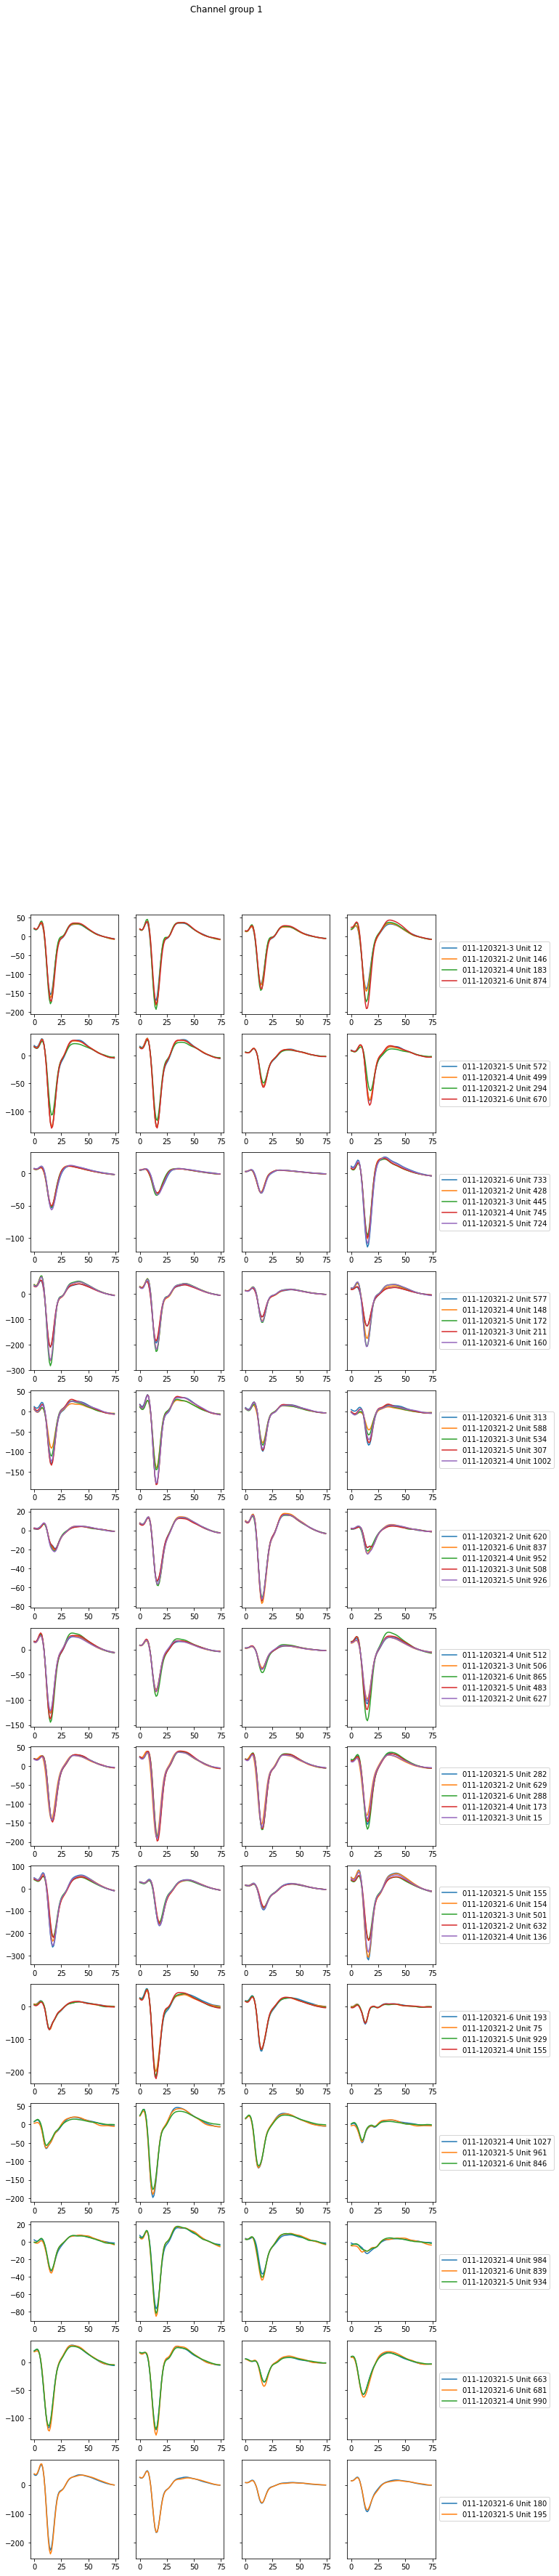

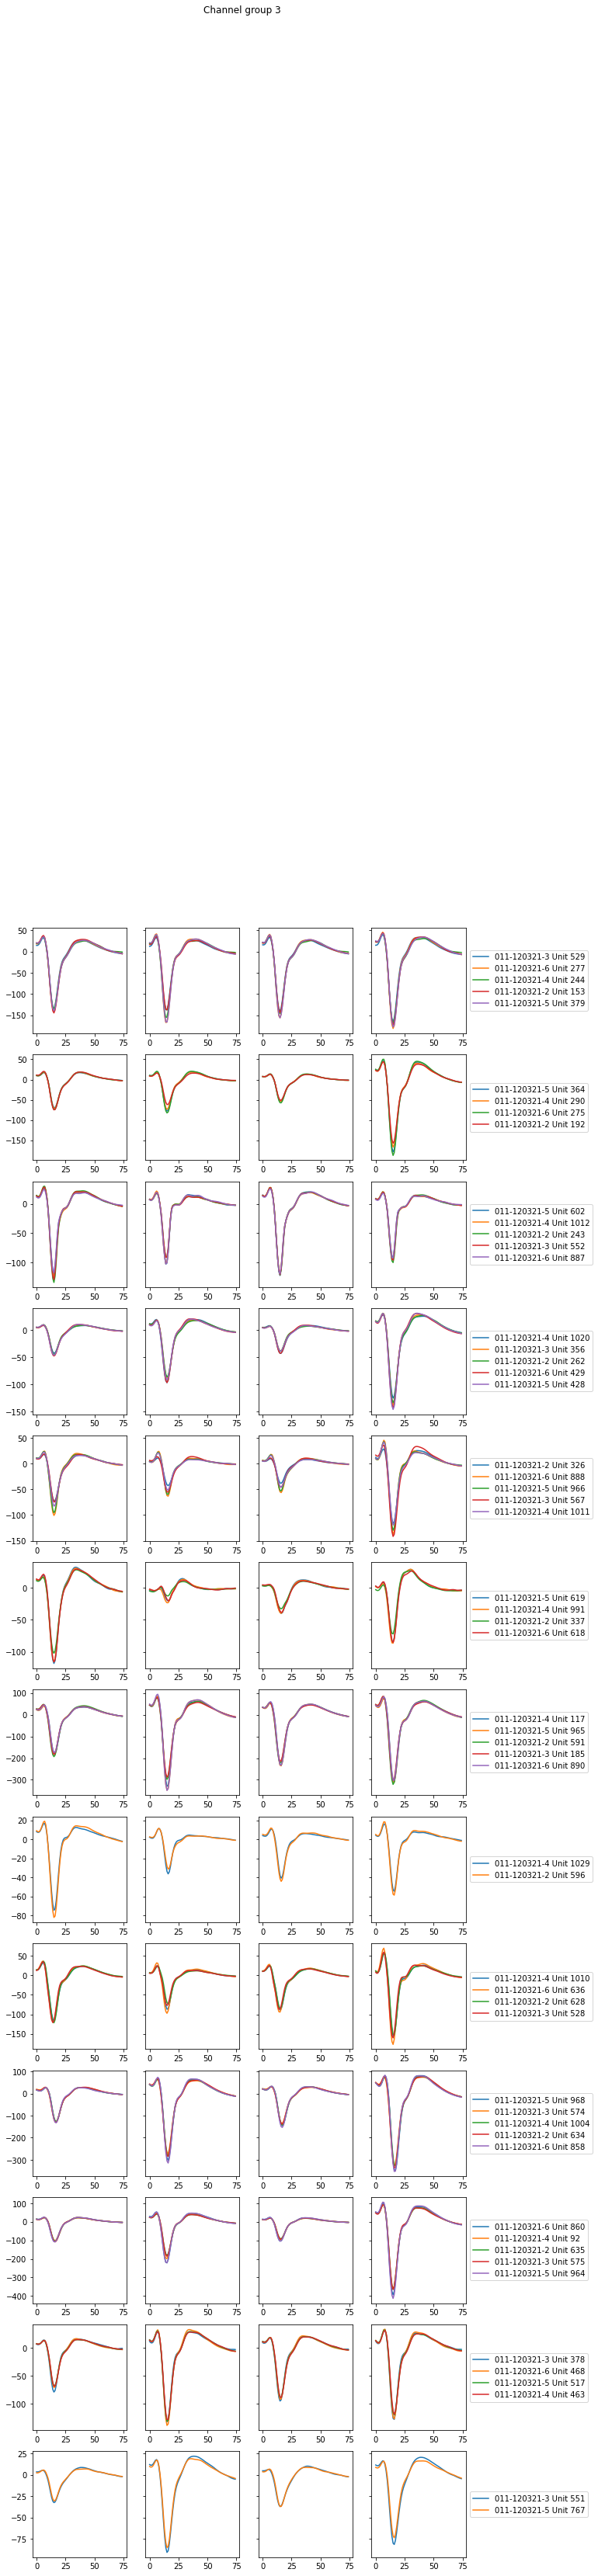

In [18]:
#unit_comp.plot_matches('template', chan_group=1, step_color=False)
unit_comp.plot_matches('template', step_color=False)

#plt.tight_layout()

# Store uniqe unit ids to csv

In [19]:
max_dissimilarity = .05 #default 0.05
max_depth_delta = 100
id_nums = {}
num = 0
output = identify_neurons.data_path()

for entity, values in sessions_include.groupby('entity'):
    data_path = output / f'{entity}-graphs'
    unit_matching = TrackMultipleSessions(
        actions, values.action.values.tolist(), 
        progress_bar=tqdm, verbose=False, data_path=data_path
    )
    unit_matching.load_graphs()
    # cutoff large dissimilarities
    unit_matching.remove_edges_above_threshold('weight', max_dissimilarity)
    unit_matching.remove_edges_above_threshold('depth_delta', max_depth_delta)
    unit_matching.remove_edges_with_duplicate_actions()
    unit_matching.identify_units()
    units = []
    for ch, group in unit_matching.identified_units.items():
        for unit_id, val in group.items():
            for action_id, orig_unit_ids in val['original_unit_ids'].items():
                if unit_id not in id_nums:
                    id_nums[unit_id] = num
                    num += 1
                units.extend([
                    {
                        'unit_name': name, 
                        'unit_idnum': id_nums[unit_id],
                        'unit_id': unit_id, 
                        'action': action_id,
                        'channel_group': ch,
                        'max_dissimilarity': max_dissimilarity,
                        'max_depth_delta': max_depth_delta
                    } 
                    for name in orig_unit_ids])
    units = pd.DataFrame(units)
    units = units[~units.action.isin(skip_actions)]
    units.to_csv(output / f'{entity}-units.csv', index=False)

In [20]:
unique_units = pd.concat([
    pd.read_csv(p) 
    for p in output.iterdir() 
    if p.name.endswith('-units.csv')])

In [21]:
unique_units.to_csv(output / 'units.csv', index=False)

# Store results in Expipe action

In [22]:
identify_neurons.data['sessions'] = 'sessions.csv'
identify_neurons.data['units'] = 'units.csv'

In [23]:
copy_tree(output, str(identify_neurons.data_path()))

DistutilsFileError: could not delete 'D:\projects\hpc-social\actions\identify-neurons\data\00-identify-neurons.html': The process cannot access the file because it is being used by another process

In [24]:
store_notebook(
    identify_neurons, "00-identify-neurons.ipynb")

## Load and view results

In [25]:
pd.read_csv(output / "units.csv")

,unit_name,unit_idnum,unit_id,action,channel_group,max_dissimilarity,max_depth_delta
0,422,0,cddea938-4e94-4c8e-837f-e03f68d0e824,002-050721-1,0,0.05,100
1,227,0,cddea938-4e94-4c8e-837f-e03f68d0e824,002-050721-3,0,0.05,100
2,294,0,cddea938-4e94-4c8e-837f-e03f68d0e824,002-050721-2,0,0.05,100
3,4,0,cddea938-4e94-4c8e-837f-e03f68d0e824,002-050721-4,0,0.05,100
4,95,0,cddea938-4e94-4c8e-837f-e03f68d0e824,002-050721-5,0,0.05,100
...,...,...,...,...,...,...,...
528,332,28,352e4452-549c-41c8-a590-a18abad46257,001-280721-5,5,0.05,100
529,37,29,71b38fcd-f01c-45d6-acd4-5d0e3e372a54,001-280721-1,5,0.05,100
530,49,29,71b38fcd-f01c-45d6-acd4-5d0e3e372a54,001-280721-2,5,0.05,100
531,607,30,8058fd3c-928e-4360-b0e1-6a0195fc7649,001-280721-2,5,0.05,100


In [26]:
pd.read_csv(output / "units.csv")["unit_id"].unique()

array(['cddea938-4e94-4c8e-837f-e03f68d0e824',
       '9402104a-affd-484e-97bb-ddc4f94dbc63',
       'f09a0bca-44c4-442a-a8dc-148177347bed',
       'e557e5bd-2faa-43e2-985a-b5d9c4783c50',
       '081a300a-4c54-4c55-a00e-f5260056d8a2',
       '238ce97d-580a-479d-b5a5-2122b2b8bb02',
       'd644352f-c37b-47c2-8319-6f9747162101',
       '192344ef-8575-426e-83fe-7b521c92c2a4',
       '1de6650e-5af0-4180-9b18-413b14c7dea7',
       'be92476e-7720-46c6-8091-4c856fc44592',
       'fb4572a2-5d0c-4a07-92a7-e200fccc415d',
       '1d2b93a7-720e-4007-9c9c-056aa6209a6a',
       'e86d3038-6d63-427a-826c-ab20b71ce319',
       '3d0e7c37-8030-421c-b508-b772ad049f84',
       'a4d8ddd4-52dc-4582-a01d-fd53a324e9fe',
       '0529b001-986c-4fb0-b14f-702c5b8d6b98',
       'fa2622c2-a517-4de6-9d0b-3a482b7cbe25',
       '5706f797-dba7-4423-b845-6d9cd2d520f6',
       '00f42505-0954-45a2-9e37-2fdfdc7920e0',
       'd88388c9-a112-4e07-a6da-125d84e28a08',
       'cc1b3113-a1db-4048-b776-29f7b1384736',
       '77bfc